# Generate synthetic scRNA-seq count data

This notebook generates synthetic count data for two realistic models of transcription: "constitutive" transcription which results in Poisson distributed single cell RNA counts for spliced and unspliced species, and "burst" transcription, which results in a distribution of spliced and unspliced RNA with no closed form solution.





In [ ]:
# !pip install anndata scanpy==1.7.2 -q
# %pip install loompy
#  %pip install leidenalg

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2e1a562050>)

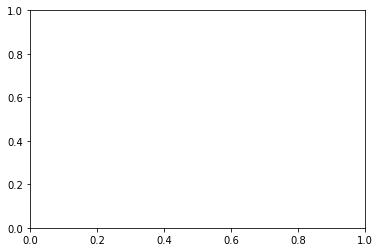

In [ ]:
# System
import os, time
import sys

# Math
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import torch
import scipy
torch.set_default_tensor_type(torch.FloatTensor)


# sc Processing
# import anndata
# import scanpy as sc

# Plots
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.subplots()


In [ ]:
# mount to drive and change directory
from google.colab import drive
drive.mount('/content/drive')


# CHANGE TO SHARED DIRECTORY HERE 
%cd /content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/

In [ ]:
# import model 

import reformat_model
import exact_cme

ModuleNotFoundError: ignored

# Generate parameters


Parameters for cell type will be stored in numpy arrays of shape ( cell_type, gene, parameter): ( N_ct, N_g, 3) for bursty transcription and (N_ct, N_g, 2) for constitutive transcription, where N_ct is the number of cell types, N_g is the number of genes, and 2 and 3 are the number of parameters in bursty and constitutive models of transcription respectively. 

In [ ]:
# # LOG of mean and LOG of std dev
# mu_b = 0.2
# mu_beta = 0.5
# mu_gamma = 0.4

# std_b =  0.6
# std_beta = 0.3
# std_gamma = 0.5


# generate genes
def generate_gene_parameters(N_ct, N_g, 
                                    mu_array =  [0.2,0.5,0.4],
                                    std_array = [0.6,0.3,0.5],
                                    correlation_coeff = 0.8,
                                    N_mg = 25,
                                    std_eps = 0.05,
                                    bursty = True):
  ''' Generates the log of gene parameters for a given number of cell types N_ct for a given number of genes N_g. Assumes a bursty model of transcription. 

  Parameters
  ------
  N_ct : number of cell types
  N_g : number of genes


  Optional
  ------
  mu_array : array of means for b, beta, gamma
  std_array : array of standard deviation for b, beta, gamma
  correlation_coeff : correlation scaling to generate parameters for each gene from a correlated multivariate normal dist.
  N_mg : average number of marker genes per cell type (average of a Poisson distribution)
  std_eps : standard deviation for normally distributed random variable used to add noise to housekeeper gene parameters


  Returns
  ------
  param_array = array of size (N_ct, N_g, 3) : 
  '''

  mu_array = np.array(mu_array)
  std_array = np.array(std_array)

  if bursty == False:
    N_params = 2
    if len(mu_array) == 3:
      mu_array = mu_array[1:]
      std_array = std_array[1:]
  else:
    N_params = 3

  # setup covariance matrix
  cov_array = np.zeros((N_params,N_params))

  for i in range(N_params):
    for j in range(N_params):
      rho = correlation_coeff
      if i == j :
        rho = 1
      cov_ij = std_array[i]*std_array[j]*rho
      cov_array[i,j] = cov_ij


  # set up array to store parameters
  param_array = np.zeros((N_ct,N_g,N_params))

  # generate housekeeping genes from multivariate normal distribution
  baseline_params = np.random.multivariate_normal(mean= mu_array, cov = cov_array, size = N_g)

  for ct in range(N_ct):
    param_array[ct,:,:] = baseline_params 
  
  # add some random noise to housekeeping genes
  param_array = param_array + np.random.normal(loc = 0, scale = std_eps, size = (N_ct,N_g,N_params))

  # MARKER genes YAHOO
  possible_marker_genes = list(range(N_g))

  for ct in range(N_ct):
    # choose number of marker genes from Poisson distribution with default average of 25
    num_mg_ = np.random.poisson(lam = N_mg) + 2

    # select which genes they are randomly 
    mg_index = np.array(random.sample(possible_marker_genes,num_mg_))

    # remove the marker genes so that there are no overlapping MGs
    possible_marker_genes = [mg for mg in possible_marker_genes if mg not in mg_index]


    if bursty == False:
      # does k, transcriptional initiation rate, or gamma, degradation, change? 
      a = np.random.uniform(0,1,size = num_mg_)
      mg_k_increase = mg_index[a > 0.45]
      mg_gamma_decrease = mg_index[a < 0.45]

      # modulate marker gene expression
      param_array[ct,mg_k_increase,:] = param_array[ct,mg_k_increase,:] - np.random.normal(loc=1.2, scale = 0.1, size = (len(mg_k_increase),2))
      param_array[ct,mg_gamma_decrease,1] = param_array[ct,mg_gamma_decrease,1] - np.random.normal(loc=1.2, scale = 0.1, size = len(mg_gamma_decrease) )
      
    else: 
      # does k, transcriptional initiation rate, or b, burst size, change? 
      a = np.random.uniform(0,1,size = num_mg_)
      mg_k_increase = mg_index[a < 0.45]
      mg_b_increase = mg_index[a > 0.45]

      # modulate marker gene expression
      param_array[ct,mg_k_increase,-2:] = param_array[ct,mg_k_increase,-2:] - np.random.normal(loc=1.2, scale = 0.1, size = (len(mg_k_increase),2))
      param_array[ct,mg_b_increase,0] = param_array[ct,mg_b_increase,0] + np.random.normal(loc=1.2, scale = 0.1, size = len(mg_b_increase))

  return(param_array)


Amazing! Generating gene parameters for bursty and Poisson model now works. Love that. 


Now to generate full data.

In [ ]:
def generate_count_data(N_cells, N_ct, N_g, distribution, bursty = True):
  ''' Generates count data matrix for N_cells, N_celltypes, given a distribution (bursty or constitutive).
    (If I wanted to generate uncorrelated Negative Binomial data or bivariate Negative Binomial data, how would I get the means and std from the current method of parameter sampling?)
  
  Parameters 
  ------
  N_cells : rough number of cells in the count matrix (will be slightly more because rounding up)
  N_ct : number of cell types
  N_genes : number of genes per cell
  distribution : function that defines the distribution to sample from 
  bursty : bursty or constitutive transcription (bool)


  Returns
  -----
  count_matrix : matrix of size ( ~N_cells, N_g, 2) where the third dimension is spliced, unspliced counts. 
  params : parameters for model of transcription of size (N_ct,N_g, 2/3) 
  cells_per_ct : cells per cell type
  count_matrix_MMNB : matrix ( ~N_cells, N_g, 2) sampled from MMNB approximation
  '''

  # calculate the proportion of cells in each cell type -- dirichlet distribution
  alpha = np.ones(N_ct)*4.0  # could change -- i think the higher the multiplied value, the more even the # cells per ct will be
  ct_proportions = np.random.dirichlet(alpha)

  # calculate the number of cells per cell type
  cells_per_ct = np.ceil(ct_proportions * N_cells)

  # set up count matrix -- spliced and unspliced
  count_matrix = np.zeros((int(np.sum(cells_per_ct)),N_g,2))
  count_matrix_MMNB = np.zeros((int(np.sum(cells_per_ct)),N_g,2))  

  # generate log of parameters for all genes for each cell type
  params = generate_gene_parameters(N_ct, N_g , bursty = bursty)

  for i,ct in enumerate(range(N_ct)):

    num_cells_ = cells_per_ct[i]
    params_ = params[ct,:,:]
    
    # generates count matrix of size (num_cells_ , N_g, 2) given distribution and parameters of the distribution
    count_data_ct, count_data_ct_MMNB = distribution(int(num_cells_) , params_) 

    count_matrix[int(np.sum(cells_per_ct[:i])):int(np.sum(cells_per_ct[:i+1])), :, :] = count_data_ct 
    count_matrix_MMNB[int(np.sum(cells_per_ct[:i])):int(np.sum(cells_per_ct[:i+1])), :, :] = count_data_ct_MMNB


  return(count_matrix,params,cells_per_ct,count_matrix_MMNB)
    

In [ ]:
# sampling distributions

def constitutive_transcription(num_cells, log_params):
  ''' Produces a count matrix for num_cells_ given constitutive model of transcription and parameters. Spliced and unspliced.
  Uncorrelated Poisson distribution.

  Parameters
  -----
  num_cells : number of cells for which to generate counts
  params : parameters for each gene for a constitutive model of transcription

  Returns
  ---
  count_data : array of size (num_cells_, len(params), 2) with spliced and unspliced data
  '''

  params = 10**log_params
  nascent_means = 1/params[:,0]
  mature_means = 1/params[:,1]

  nascent_counts = np.random.poisson(lam = nascent_means,size = (num_cells,len(params)))
  mature_counts = np.random.poisson(lam = mature_means,size = (num_cells,len(params)))


  count_data = np.zeros((num_cells,len(params),2))
  count_data[:,:,0] = nascent_counts
  count_data[:,:,1] = mature_counts

  return(count_data)


def bursty_transcription(num_cells, log_params):
  ''' Generates count data for a bursty model of transcription. Spliced and unspliced data.

  Sampling from neural network works as follows:

  1. Pull from nascent NB given moments of the CME solution to get nascent counts. 
  2. Run the parameter through the NN to return weights and hyperparameters. 
  3. Pull from a discrete distribution of kernel functions with probabilities given by NN weights. 
  4. Sample from the NB kernel function of the chosen kernel function to get mature counts. 

  Parameters
  ------
  num_cells : number of cells to generate count data for
  log_params : parameters of genes for a bursty model of transcription (log of params)

  Returns
  ------
  count_matrix : matrix of count data size (num_cells, N_g, 2) sampled from neural network
  count_matrix_MMNB : count matrix sampled from MMNB approximation
  '''
  eps = 1e-8

  params = 10**log_params
  b,beta,gamma = params[:,0],params[:,1],params[:,2]


  # calculate nascent marginal negative binomial P(n) 
  n_nascent = 1/beta
  p_nascent = 1/(b+1)

  nascent_counts = np.random.negative_binomial(n = n_nascent, p = p_nascent, size = (num_cells, len(params)))

  weights, n_10_mature, p_10_mature, mu_10_mature, logmean_cond, logvar_cond = get_NN_weights_NB_params(params, nascent_counts.flatten(), num_cells)

  n_mature, p_mature, mu_mature = np.zeros(len(nascent_counts.flatten())), np.zeros(len(nascent_counts.flatten())), np.zeros(len(nascent_counts.flatten()))

  mature_counts = np.zeros(len(nascent_counts.flatten()))
  mature_counts_MMNB = np.zeros(len(nascent_counts.flatten()))

  for i,n in enumerate(nascent_counts.flatten()):
    
    weights_ = weights[i]
    n_10_mature_ = n_10_mature[i]
    p_10_mature_ = p_10_mature[i]
    mu_10_mature_ = mu_10_mature[i]
    var_10_mature_ = mu_10_mature_/(1-p_10_mature_)

    # THIS IS IF YOU WANT TO APPROXIMATE THE APPROXIMATION -- then comment out below n_mature[i],etc. commands
    # mu_i = np.sum(mu_10_mature_*weights_)
    # var_i = np.sum((weights_**2)*var_10_mature_)
    # n_i = mu_i**2/(var_i-mu_i)
    # p_i = mu_i/var_i
    # n_mature[i], p_mature[i], mu_mature[i] = n_i, p_i, mu_i

    # sample from neural network weights
    NB_index = np.random.choice(range(10),p = weights_)

    # IF YOU WANT TO SET NB index to the kernel with the MAX WEIGHT
    #NB_index = np.where(weights_ == np.max(weights_))

    n_mature[i], p_mature[i], mu_mature[i] = n_10_mature_[NB_index], p_10_mature_[NB_index], mu_10_mature_[NB_index]



  # calculate MMNB means, etc. 
  mean_cond = np.exp(logmean_cond + logvar_cond/2)
  var_cond = np.exp(2*logmean_cond + logvar_cond) * (np.exp(logvar_cond) - 1)
  n_cond = mean_cond**2/(var_cond-mean_cond)
  p_cond = mean_cond/var_cond

  filt_nb = np.logical_and(p_cond > 1e-10, n_cond > 0)
  filt_poisson = ~filt_nb

  # sampled from MMNB
  mature_counts_MMNB[filt_poisson] =  np.random.poisson(lam = mu_mature[filt_poisson])
  mature_counts_MMNB[filt_nb] =  np.random.negative_binomial(n = n_cond[filt_nb], p = p_cond[filt_nb])
  mature_counts_MMNB = mature_counts_MMNB.reshape(nascent_counts.shape)

  # sampled from neural network chosen kernels
  index_nb = np.logical_and(p_mature > 1e-10, n_mature > 0)
  index_poisson = ~index_nb
  mature_counts[index_poisson] = np.random.poisson(lam = mu_mature[index_poisson])
  mature_counts[index_nb] = np.random.negative_binomial(n = n_mature[index_nb], p = p_mature[index_nb])
  mature_counts = mature_counts.reshape(nascent_counts.shape)

  count_data = np.zeros((num_cells,len(params),2))
  count_data[:,:,0] = nascent_counts
  count_data[:,:,1] = mature_counts

  count_data_MMNB = np.zeros((num_cells,len(params),2))
  count_data_MMNB[:,:,0] = nascent_counts
  count_data_MMNB[:,:,1] = mature_counts_MMNB


  return(count_data, count_data_MMNB)

In [ ]:
def get_NN_weights_NB_params(params, nascent_values, num_cells):
    ''' Get kernel weights and params using neural network. Also returns lognormal approximation con 

    Parameters 
    ------
    params: parameters of a bursty model of transcription (b,beta,gamma) NOT LOG -- IMPORTANT
    nascent_values : nascent count values at which to evaluate
    num_cells : number of cells of given cell type

    Returns
    ------
    weights : weights for the NB distribution for each cell/gene
    r : r values for kernel functions(Negative Binomial)
    p : p values for kernel functions (Negative Binomial)
    grid : means of kernel functions 
    logmean_cond : conditional logmean given lognormal approximation
    logvar_cond : conditional logvariance given lognormal approximation
    '''
    b,beta,gamma = torch.tensor(params[:,0]).repeat(num_cells),torch.tensor(params[:,1]).repeat(num_cells),torch.tensor(params[:,2]).repeat(num_cells)
    mu1,mu2 = b/beta, b/gamma

    # get moments
    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)

    nascent_values = torch.tensor(nascent_values)

    # calculate conditional moments
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    # val = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    # val[val<-88] = -88

    logcov = np.log(cov * np.exp(-(logmean1 + logmean2 + (logvar1+logvar2)/2) ) + 1 )
    #logcov = torch.log(cov * torch.exp(-(val)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)

    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(nascent_values+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)  

    xmax_m = torch.ceil(torch.ceil(mu2) + 4*torch.sqrt(var2))
    xmax_m = torch.clip(xmax_m,30,np.inf).int()
  

    # reshape and stack
    pv = torch.column_stack((torch.log10(b).reshape(-1),
                             torch.log10(beta).reshape(-1),
                             torch.log10(gamma).reshape(-1),
                             logmean_cond.reshape(-1),
                             logstd_cond.reshape(-1),
                             xmax_m.reshape(-1),
                             nascent_values.reshape(-1)
                             ))
    
    pv = pv.to(torch.float)


    # run through model
    w,hyp = reformat_model.model(pv.to(torch.device('cuda')))

    hyp = hyp*5+1

    p_vec = 10**pv[:,0:3]
    logmean_cond = pv[:,3]
    logstd_cond = pv[:,4]
        
    grid = reformat_model.generate_grid(logmean_cond,logstd_cond,reformat_model.NORM).to(torch.device('cuda'))

    s = torch.zeros((len(nascent_values),10)).to(torch.device('cuda'))
    s[:,:-1] = torch.diff(grid,axis=1)
    s *= hyp
    s[:,-1] = torch.sqrt(grid[:,-1])
    v = s**2
    r = grid**2/(v-grid)
    p_nb = 1-grid/v

    #return(w.cpu(),hyp.cpu(),pv.cpu())
    return(w.cpu().detach().numpy(),r.cpu().detach().numpy(),p_nb.cpu().detach().numpy(), grid.cpu().detach().numpy(),logmean_cond.cpu().detach().numpy(),logvar_cond.cpu().detach().numpy())

In [ ]:

# small note -- if this breaks, try increasing the number of genes -- it draws from a Poisson distribution of mean 25 to get marker genes :D

bursty_counts,bursty_params,cells_per_ct,bursty_counts_MMNB = generate_count_data(N_cells = 7000, N_ct = 1, N_g = 35, distribution = bursty_transcription, bursty = True)

# Check Bursty Model



Compare bursty model of transcription against true CME solutions. Figure out what might be going wrong.

In [ ]:
from exact_cme import calculate_exact_cme

In [ ]:
gene = 1
nascent = bursty_counts[:,gene,0]
mature = bursty_counts[:,gene,1]

nascent_MMNB = bursty_counts_MMNB[:,gene,0]
mature_MMNB = bursty_counts_MMNB[:,gene,1]


gene_param = bursty_params[0,gene,:]


# calculate exact CME at given gene
def x_func(x):
  '''4 sigma away is the default. If you return x/4, this will calculate CME over grid (nascent mean, mature mean). If you return in x/2, will calculate over (nascent_mean + 2std_dev, mature_mean +2std_dev).
  '''
  return(x)

params, CME_ground_truth = exact_cme.calculate_exact_cme(gene_param,'quad_vec',x_func)

n = CME_ground_truth.shape[0]
m = CME_ground_truth.shape[1]

In [ ]:
# sample from CME
possible_n_m = [(i,j) for i in range(CME_ground_truth.shape[0]) for j in range(CME_ground_truth.shape[1])]
index = np.random.choice(range(len(possible_n_m)), p = CME_ground_truth.flatten(),size = 7000)
n_m_selected = np.array(possible_n_m)[index]
nascent_CME = n_m_selected[:,0]
mature_CME = n_m_selected[:,1]

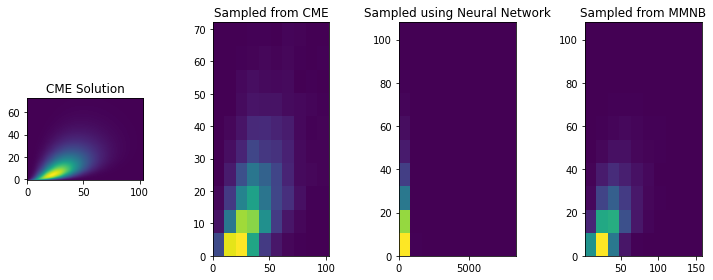

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(10,4))


ax[0].set_title('CME Solution')
ax[0].imshow(CME_ground_truth)
ax[0].invert_yaxis()
# ax[1].set_xlim(0,16)
# ax[1].set_ylim(0,7)

ax[1].hist2d(mature_CME,nascent_CME)
ax[1].set_title('Sampled from CME')

ax[2].hist2d(mature,nascent)
ax[2].set_title('Sampled using Neural Network')
#ax[1].set_xlim(0,40)
#ax[1].set_ylim(0,7)

ax[3].hist2d(mature_MMNB,nascent_MMNB)
ax[3].set_title('Sampled from MMNB');

plt.tight_layout()

### Marginal Distributions

9.810994873687678 0.5792162485252662 0.27299656687358353


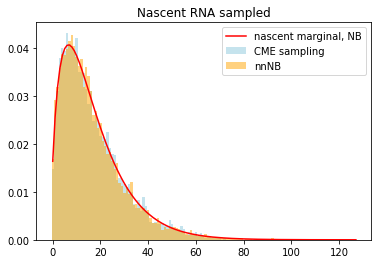

In [ ]:
# PLOT MARGINAL distribution for nascent -- sampled vs. true
b,beta,gamma = 10**gene_param
print(b,beta,gamma)
p_nb = 1/(b+1)
n_nb = 1/beta
bins = np.arange(nascent.max()+2)-0.5
plt.hist(nascent_CME,bins,color='lightblue',density=True,label='CME sampling',alpha=0.7)
plt.hist(nascent,bins,color='orange',density=True,label='nnNB',alpha=0.5)
x = np.arange(nascent.max()+20)
y = scipy.stats.nbinom.pmf(x,n_nb,p_nb)
plt.plot(x,y,'r-',label='nascent marginal, NB')
plt.legend()
plt.title('Nascent RNA sampled');

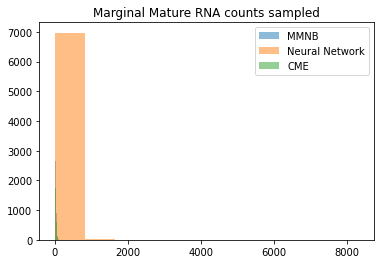

In [ ]:
# NOW, plot mature marginals from nnNB, MMNB, and CME sampling :D 
# AHHH looks bad. A note -- if you set the index to be the kernel with the max weight using the neural network output, it actually looks fairly good

plt.hist(mature_MMNB,label='MMNB',alpha=0.5)
plt.hist(mature,label='Neural Network',alpha=0.5)
plt.hist(mature_CME,label='CME',alpha=0.5)

plt.title('Marginal Mature RNA counts sampled')
plt.legend();